In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

# URL của trang web để lấy dữ liệu
url = "https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_Vietnam"

# Gửi yêu cầu GET tới trang web
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Tìm tất cả các bảng có class 'wikitable'
tables = soup.find_all('table', class_='wikitable')

# Hàm để lấy dữ liệu từ một bảng với tiêu đề đã chỉ định
def scrape_airport_data(required_headers):
    data = []  # Danh sách để lưu trữ dữ liệu
    for table in tables:
        # Lấy tiêu đề cột
        headers = [th.text.strip() for th in table.find_all('th')]

        # Kiểm tra xem tất cả các tiêu đề yêu cầu có trong tiêu đề cột hay không
        if all(header in headers for header in required_headers):
            # Lấy dữ liệu từ bảng
            rows = table.find_all('tr')[1:]  # Bỏ qua hàng tiêu đề
            for row in rows:
                cols = [td.text.strip() for td in row.find_all('td')]
                # Chỉ thêm dữ liệu nếu số lượng cột khớp với tiêu đề
                if len(cols) == len(required_headers):
                    # Xử lý từng cột: loại bỏ số trong ngoặc và chuyển đổi giá trị null/unknown thành 0
                    processed_cols = []
                    for col in cols:
                        # Loại bỏ số trong ngoặc
                        col = re.sub(r'\[\d+\]', '', col).strip()
                        # Chuyển đổi 'null' hoặc 'unknown' thành '0'
                        if col.lower() in ['null', 'unknown']:
                            col = '0'
                        processed_cols.append(col)  # Thêm cột đã xử lý vào danh sách
                    data.append(processed_cols)
    return data

# Định nghĩa tiêu đề yêu cầu cho cả hai tập dữ liệu
required_headers_2020s = ['No.', 'Airport name', 'Province', 'City served', 'IATA', 'ICAO', '2020', '2021', '2022', '2023']
required_headers_2012s = ['No.', 'Airport name', 'Province', 'City served', 'IATA', 'ICAO', '2012[17]', '2013[17]', '2014[17]', '2015[18]', '2016[17]', '2017', '2018[19]', '2019[20][21]']

# Lấy dữ liệu cho những năm 2020 và lưu vào CSV
data_2020s = scrape_airport_data(required_headers_2020s)
if data_2020s:
    df_2020s = pd.DataFrame(data_2020s, columns=required_headers_2020s)
    df_2020s.to_csv('airports_data2020s.csv', index=False)
    print("Dữ liệu đã được lưu vào airports_data2020s.csv.")
else:
    print("Không có dữ liệu nào được tìm thấy với các tiêu đề cột yêu cầu cho 2020s.")

# Lấy dữ liệu cho những năm 2012 và lưu vào CSV
data_2012s = scrape_airport_data(required_headers_2012s)
if data_2012s:
    df_2012s = pd.DataFrame(data_2012s, columns=required_headers_2012s)
    df_2012s.to_csv('airports_data2012s.csv', index=False)
    print("Dữ liệu đã được lưu vào airports_data2012s.csv.")
else:
    print("Không có dữ liệu nào được tìm thấy với các tiêu đề cột yêu cầu cho 2012s.")

# Hợp nhất hai tệp CSV
# Tải hai tệp CSV vào DataFrames
df_2020s = pd.read_csv('airports_data2020s.csv')
df_2012s = pd.read_csv('airports_data2012s.csv')

# Hợp nhất hai DataFrame trên một cột chung (ví dụ: 'No.')
merged_df = pd.merge(df_2012s, df_2020s, on='No.', how='outer')

# Loại bỏ các hậu tố khỏi các cột
merged_df.columns = [col.split('_')[0] if '_' in col else col for col in merged_df.columns]

# Loại bỏ số trong ngoặc khỏi tên cột
merged_df.columns = [re.sub(r'\[\d+\]', '', col).strip() for col in merged_df.columns]

# Loại bỏ các cột trùng lặp, giữ lại chỉ lần xuất hiện đầu tiên
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

# Giữ lại chỉ các cột đã chỉ định
columns_to_keep = [
    'No.', 'Airport name', 'Province', 'City served', 'IATA', 'ICAO',
    '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
    '2020', '2021', '2022', '2023'
]
merged_df = merged_df[columns_to_keep]

# Lưu DataFrame đã hợp nhất vào một tệp CSV mới
merged_df.to_csv('merged_airports_data.csv', index=False)
print("Dữ liệu đã được lưu vào merged_airports_data.csv.")


Dữ liệu đã được lưu vào airports_data2020s.csv.
Dữ liệu đã được lưu vào airports_data2012s.csv.
Dữ liệu đã được lưu vào merged_airports_data.csv.


In [3]:
merged_df.head()

,No.,Airport name,Province,City served,IATA,ICAO,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,1,Tan Son Nhat International Airport,Ho Chi Minh City,Ho Chi Minh City,SGN,VVTS,"17,538,353","20,035,152","22,153,349","26,546,475","32,486,537","35,996,014","38,414,737","41,243,240","22,062,893","10,287,611","34,278,320","40,738,295"
1,2,Noi Bai International Airport,Hanoi,Hanoi,HAN,VVNB,"11,341,039","12,825,784","14,190,675","17,213,715","20,596,632","23,824,400","25,908,048","29,304,631","16,473,214",Un­known,"24,430,000","29,800,000"
2,3,Da Nang International Airport,Da Nang,Da Nang,DAD,VVDN,"3,090,877","4,376,775","4,989,687","6,722,587","8,783,429","10,801,927","13,229,663","15,543,598",Un­known,Un­known,"8,900,000",Un­known
3,4,Cam Ranh International Airport,Khánh Hòa,Nha Trang,CXR,VVCR,"1,095,776","1,509,212","2,062,494","2,722,833","4,858,362","6,500,000","8,250,000","9,747,172","3,305,057","972,817","3,860,541","5,700,000"
4,5,Phu Quoc International Airport,Kiên Giang,Phú Quốc,PQC,VVPQ,"493,434","685,036","1,002,750","1,467,043","2,278,814","3,000,000","3,200,000","3,700,205",Un­known,Un­known,"5,500,000",Un­known


In [4]:
merged_df.columns

Index(['No.', 'Airport name', 'Province', 'City served', 'IATA', 'ICAO',
       '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021', '2022', '2023'],
      dtype='object')

Ở các cột năm, định dạng số về số nguyên, đưa giá trị 'Unknown' và null về 0

In [5]:
# Chỉ định các cột để kiểm tra chuyển đổi sang kiểu số
numeric_columns = ['2012', '2013', '2014', '2015', '2016', '2017',
                   '2018', '2019', '2020', '2021', '2022', '2023']

# Loại bỏ các cột không cần thiết
columns_to_drop = ['No.', 'Province', 'City served', 'IATA', 'ICAO']
merged_df.drop(columns=columns_to_drop, inplace=True)

# Chuyển đổi các giá trị chuỗi có dấu phẩy sang kiểu số nguyên và xử lý các giá trị không phải số
for col in numeric_columns:
    # Loại bỏ dấu phẩy, chuyển đổi sang kiểu số, và thiết lập phân tích không hợp lệ thành NaN
    merged_df[col] = pd.to_numeric(merged_df[col].str.replace(',', ''), errors='coerce').fillna(0)

# Chuyển đổi các giá trị không phải số trong các cột đã chỉ định thành 0 (đã được xử lý ở trên)
# Tùy chọn, chuyển các cột sang kiểu số nguyên sau khi thay thế NaN bằng 0
merged_df[numeric_columns] = merged_df[numeric_columns].astype(int)

# Hiển thị vài hàng đầu tiên của DataFrame đã được chỉnh sửa
print(merged_df.head())


                         Airport name      2012      2013      2014      2015  \
0  Tan Son Nhat International Airport  17538353  20035152  22153349  26546475   
1       Noi Bai International Airport  11341039  12825784  14190675  17213715   
2       Da Nang International Airport   3090877   4376775   4989687   6722587   
3      Cam Ranh International Airport   1095776   1509212   2062494   2722833   
4      Phu Quoc International Airport    493434    685036   1002750   1467043   

       2016      2017      2018      2019      2020      2021      2022  \
0  32486537  35996014  38414737  41243240  22062893  10287611  34278320   
1  20596632  23824400  25908048  29304631  16473214         0  24430000   
2   8783429  10801927  13229663  15543598         0         0   8900000   
3   4858362   6500000   8250000   9747172   3305057    972817   3860541   
4   2278814   3000000   3200000   3700205         0         0   5500000   

       2023  
0  40738295  
1  29800000  
2         0  
3   57

In [6]:
merged_df.head()

,Airport name,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Tan Son Nhat International Airport,17538353,20035152,22153349,26546475,32486537,35996014,38414737,41243240,22062893,10287611,34278320,40738295
1,Noi Bai International Airport,11341039,12825784,14190675,17213715,20596632,23824400,25908048,29304631,16473214,0,24430000,29800000
2,Da Nang International Airport,3090877,4376775,4989687,6722587,8783429,10801927,13229663,15543598,0,0,8900000,0
3,Cam Ranh International Airport,1095776,1509212,2062494,2722833,4858362,6500000,8250000,9747172,3305057,972817,3860541,5700000
4,Phu Quoc International Airport,493434,685036,1002750,1467043,2278814,3000000,3200000,3700205,0,0,5500000,0


In [7]:
# Chuyển đổi DataFrame sang định dạng dài
melted_df = pd.melt(merged_df,
                    id_vars=['Airport name'],
                    value_vars=numeric_columns,
                    var_name='Year',
                    value_name='Passenger Count')

# Chuyển đổi cột 'Year' về kiểu số nguyên nếu cần
melted_df['Year'] = melted_df['Year'].astype(int)

# Chuyển đổi DataFrame đã được chuyển đổi để có năm làm hàng và tên sân bay làm cột
pivot_df = melted_df.pivot(index='Year', columns='Airport name', values='Passenger Count')

# Đặt lại chỉ số để làm phẳng DataFrame (tùy chọn)
pivot_df.reset_index(inplace=True)

# Hiển thị DataFrame đã được định hình lại
pivot_df.head()


Airport name,Year,NaN,Buon Ma Thuot Airport,Ca Mau Airport,Cam Ranh International Airport,Can Tho International Airport,Cat Bi International Airport,Chu Lai International Airport,Con Dao Airport,Da Nang International Airport,...,Noi Bai International Airport,Phu Bai International Airport,Phu Cat Airport,Phu Quoc International Airport,Pleiku Airport,Rạch Giá Airport,Tan Son Nhat International Airport,Tho Xuan Airport,Tuy Hoa Airport,Vinh Airport
0,2012,0,410724,37995,1095776,200751,683574,53753,191039,3090877,...,11341039,673044,236254,493434,319833,60180,17538353,0,62825,635277
1,2013,0,535084,34400,1509212,241307,872762,50974,175574,4376775,...,12825784,427582,290832,685036,319994,52409,20035152,90929,63103,917638
2,2014,0,695147,30698,2062494,305015,927001,40198,188549,4989687,...,14190675,1159499,420520,1002750,300471,33544,22153349,163270,64037,1222698
3,2015,0,830000,0,2722833,481447,1256719,154549,231679,6722587,...,17213715,1300000,630935,1467043,237564,0,26546475,570713,107843,1300000
4,2016,0,1220000,0,4858362,550090,1800000,553285,293932,8783429,...,20596632,1550000,1030000,2278814,797509,0,32486537,828930,326982,1563387


In [8]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np


# Chuẩn bị một DataFrame để lưu trữ các dự đoán
predictions = []

# Vòng lặp qua từng sân bay để xây dựng mô hình và dự đoán
for airport in pivot_df.columns[1:]:
    # Chuẩn bị dữ liệu cho sân bay này
    X = pivot_df['Year'].values.reshape(-1, 1)  # Năm là đặc trưng
    y = pivot_df[airport].values  # Số hành khách là mục tiêu

    # Xóa các giá trị NaN nếu có
    if np.any(np.isnan(y)):
        valid_indices = ~np.isnan(y)
        X = X[valid_indices]
        y = y[valid_indices]

    # Huấn luyện mô hình nếu có đủ dữ liệu
    if len(X) >= 2:  # Đảm bảo có đủ dữ liệu để xây dựng mô hình
        model = LinearRegression()
        model.fit(X, y)

        # Dự đoán cho năm tiếp theo
        next_year = np.array([[pivot_df['Year'].max() + 1]])
        predicted_passengers = model.predict(next_year)[0]

        # Lưu kết quả dưới dạng số nguyên
        predictions.append({'Airport name': airport,
                            'Predicted Passengers': int(round(predicted_passengers))})
    else:
        predictions.append({'Airport name': airport, 'Predicted Passengers': None})  # Không đủ dữ liệu

# Chuyển đổi các dự đoán thành DataFrame
predictions_df = pd.DataFrame(predictions)

# Hiển thị các dự đoán
print(predictions_df)


                          Airport name  Predicted Passengers
0                                  NaN                 96881
1                Buon Ma Thuot Airport                393873
2                       Ca Mau Airport                 -3138
3       Cam Ranh International Airport               6113270
4        Can Tho International Airport                802589
5         Cat Bi International Airport               2225046
6        Chu Lai International Airport                249989
7                      Con Dao Airport                399062
8        Da Nang International Airport               5480717
9                    Dien Bien Airport                 -7234
10                    Dong Hoi Airport                458692
11                 Lien Khuong Airport               2095871
12       Noi Bai International Airport              24113336
13       Phu Bai International Airport                929769
14                     Phu Cat Airport                338533
15      Phu Quoc Interna

In [9]:
# Giả sử predictions_df là DataFrame chứa các dự đoán
predictions_df = predictions_df.dropna()  # Xóa các giá trị NaN

predictions_df.reset_index(drop=True, inplace=True)

# Sắp xếp DataFrame theo 'Predicted Passengers' theo thứ tự giảm dần
sorted_predictions_df = predictions_df.sort_values(by='Predicted Passengers', ascending=False)

# Tùy chọn, đặt lại chỉ số sau khi sắp xếp
sorted_predictions_df.reset_index(drop=True, inplace=True)

# Hiển thị DataFrame đã sắp xếp
print(sorted_predictions_df)


                          Airport name  Predicted Passengers
0   Tan Son Nhat International Airport              35449899
1        Noi Bai International Airport              24113336
2       Cam Ranh International Airport               6113270
3        Da Nang International Airport               5480717
4                         Vinh Airport               2568648
5       Phu Quoc International Airport               2414015
6         Cat Bi International Airport               2225046
7                  Lien Khuong Airport               2095871
8                     Tho Xuan Airport               1565522
9        Phu Bai International Airport                929769
10       Can Tho International Airport                802589
11                    Dong Hoi Airport                458692
12                     Con Dao Airport                399062
13               Buon Ma Thuot Airport                393873
14                     Phu Cat Airport                338533
15       Chu Lai Interna

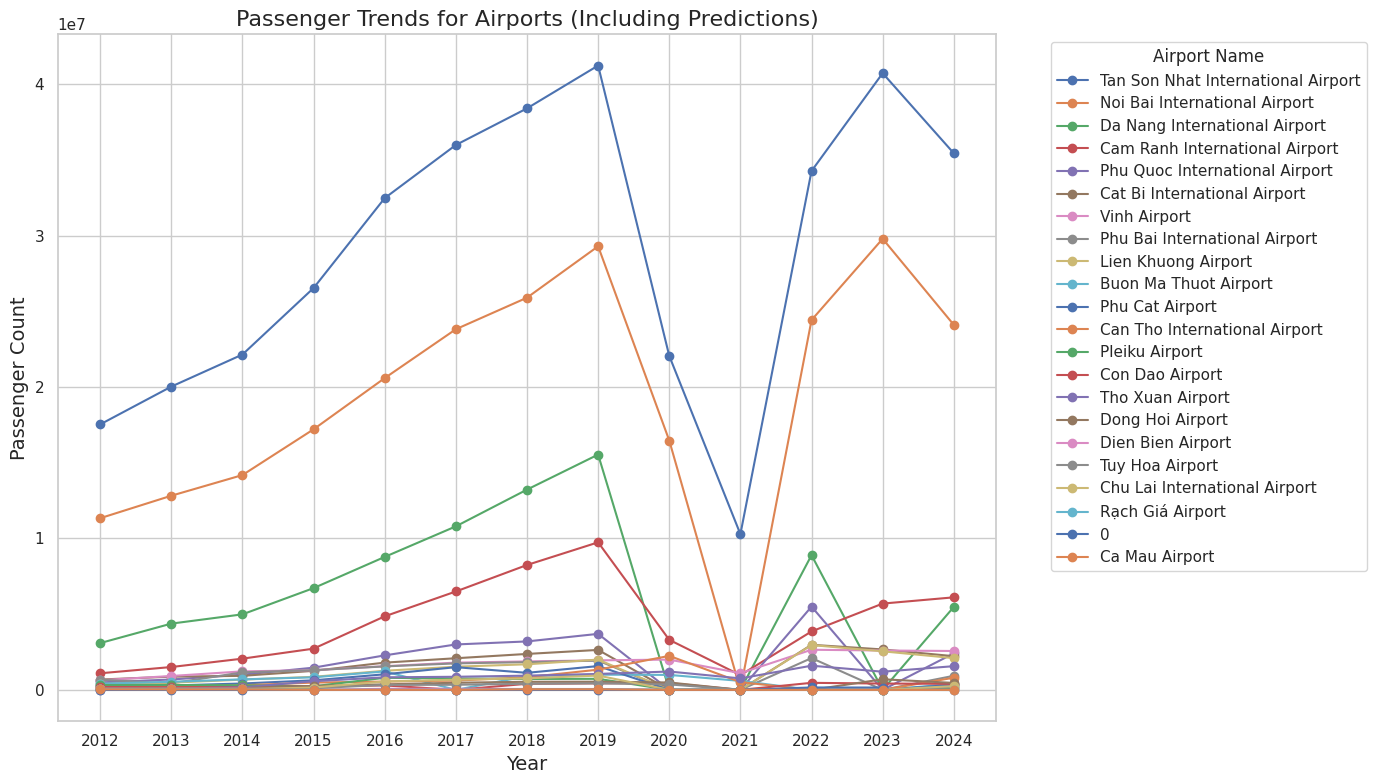

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Giả sử melted_df chứa dữ liệu lịch sử với các cột 'Year', 'Airport name', 'Passenger Count'
# Giả sử predictions_df chứa dữ liệu dự đoán với các cột 'Airport name', 'Predicted Passengers'

# Thêm cột năm cho dự đoán
max_year = melted_df['Year'].max()  # Tìm năm lớn nhất trong dữ liệu lịch sử
predictions_df['Year'] = max_year + 1  # Gán năm tiếp theo cho dữ liệu dự đoán

# Kết hợp dữ liệu lịch sử và dữ liệu dự đoán
combined_df = pd.concat([melted_df, predictions_df.rename(columns={'Predicted Passengers': 'Passenger Count'})], ignore_index=True)

# Làm sạch dữ liệu
combined_df = combined_df.fillna(0)  # Thay thế NaN bằng 0

# Đặt kiểu cho biểu đồ
sns.set(style="whitegrid")

# Tạo biểu đồ
plt.figure(figsize=(14, 8))
for airport in combined_df['Airport name'].unique():  # Lặp qua từng sân bay
    airport_data = combined_df[combined_df['Airport name'] == airport]  # Lọc cho mỗi sân bay
    plt.plot(airport_data['Year'], airport_data['Passenger Count'], marker='o', label=airport)  # Vẽ đường biểu diễn

# Tùy chỉnh biểu đồ
plt.title('Passenger Trends for Airports (Including Predictions)', fontsize=16)  # Tiêu đề
plt.xlabel('Year', fontsize=14)  # Nhãn trục x
plt.ylabel('Passenger Count', fontsize=14)  # Nhãn trục y
plt.xticks(sorted(combined_df['Year'].unique()))  # Đặt các dấu tick trên trục x là các năm
plt.legend(title='Airport Name', bbox_to_anchor=(1.05, 1), loc='upper left')  # Chú thích
plt.grid(True)  # Lưới
plt.tight_layout()  # Định dạng lại để tránh chồng chéo

# Hiển thị biểu đồ
plt.show()
